# PART I - Building a Basic Neural Network - By minazmeh and aramired

---

In [1]:
import pandas as pd
import numpy as np

# we will require this pkg to save the .pkl for the best weights
import pickle

# below are used for plotting visuals
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import time 

In [3]:
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
warnings.filterwarnings("ignore")

## STEP I

## 1.1 Read dataset

In [5]:
# read the csv file
df = pd.read_csv('datasets/dataset.csv')

In [6]:
df

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9,89,62,0,0,22.5,e,0
762,10,101,76,48,180,d,0.171,0
763,2,122,70,27,b,36.8,0.34,0
764,c,121,72,23,112,26.2,0.245,0


# 1.2 Return main stats

In [7]:
# basic stats on the df
df.describe()

,f3,target
count,766.000000,766.000000
mean,69.118799,0.349869
std,19.376901,0.477240
min,0.000000,0.000000
25%,62.500000,0.000000
50%,72.000000,0.000000
75%,80.000000,1.000000
max,122.000000,1.000000


In [8]:
# we see that not all columns are numeric
df.dtypes

f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
target     int64
dtype: object

## 1.3 Handle Invalid Entries ( Includes some preprocessing from Step 2 Handling outliers, checking for categorical data etc)

In [9]:
# figure out the non numeric entries in our df
invalid_entries = {}

for col in df.columns:
    if df[col].dtype == 'object':
        invalid_values = df[col][pd.to_numeric(df[col], errors='coerce').isna()].unique()
        if len(invalid_values) > 0:
            invalid_entries[col] = invalid_values

print("Non-numeric entries detected:")
print(invalid_entries)

Non-numeric entries detected:
{'f1': array(['c'], dtype=object), 'f2': array(['f'], dtype=object), 'f4': array(['a'], dtype=object), 'f5': array(['b'], dtype=object), 'f6': array(['d'], dtype=object), 'f7': array(['e'], dtype=object)}


In [10]:
# replace them with NA
df = df.replace(['a', 'b', 'c', 'd', 'e', 'f'], pd.NA)


In [11]:
# make the cols numeric
df['f1'] = pd.to_numeric(df['f1'], errors='coerce')
df['f2'] = pd.to_numeric(df['f2'], errors='coerce')
df['f4'] = pd.to_numeric(df['f4'], errors='coerce')
df['f5'] = pd.to_numeric(df['f5'], errors='coerce')
df['f6'] = pd.to_numeric(df['f6'], errors='coerce')
df['f7'] = pd.to_numeric(df['f7'], errors='coerce')

In [12]:
df

,f1,f2,f3,f4,f5,f6,f7,target
0,6.0,148.0,72,35.0,0.0,33.6,0.627,1
1,1.0,85.0,66,29.0,0.0,26.6,0.351,0
2,8.0,183.0,64,0.0,0.0,23.3,0.672,1
3,1.0,89.0,66,23.0,94.0,28.1,0.167,0
4,0.0,137.0,40,35.0,168.0,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9.0,89.0,62,0.0,0.0,22.5,NaN,0
762,10.0,101.0,76,48.0,180.0,NaN,0.171,0
763,2.0,122.0,70,27.0,NaN,36.8,0.340,0
764,NaN,121.0,72,23.0,112.0,26.2,0.245,0


In [13]:
# find out the NAN values in each col, We will impute them with mean using simple imputer in Step 2
print("Totol NAN Values in each feature\n", df.isna().sum())


Totol NAN Values in each feature
 f1        1
f2        1
f3        0
f4        1
f5        1
f6        1
f7        1
target    0
dtype: int64


## Also Includes Steps from Part1 Step2

In [14]:
# do we needd to preprocess our target for categorical cleaning?

print(f"Unique values in the target", df['target'].unique())

Unique values in the target [1 0]


In [15]:
# we doont need to preprocess traget col theres only 2 values (binary 0 and 1)

In [16]:
# REusing code from A1
def identify_outliers(df, column):
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    IQR = Q3 - Q1 #calculate IQR by Q3-Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_f1 = identify_outliers(df,'f1')
outliers_f2 = identify_outliers(df,'f2')
outliers_f3 = identify_outliers(df,'f3')
outliers_f4 = identify_outliers(df,'f4')
outliers_f5 = identify_outliers(df,'f5')
outliers_f6 = identify_outliers(df,'f6')
outliers_f7 = identify_outliers(df,'f7')


print("F1 outliers: ", len(outliers_f1))
print("F2 outliers: ", len(outliers_f2))
print("F3 outliers: ", len(outliers_f3))
print("F4 outliers: ", len(outliers_f4))
print("F5 outliers: ", len(outliers_f5))
print("F6 outliers: ", len(outliers_f6))
print("F7 outliers: ", len(outliers_f7))

F1 outliers:  4
F2 outliers:  5
F3 outliers:  45
F4 outliers:  1
F5 outliers:  34
F6 outliers:  19
F7 outliers:  29


In [17]:
df = df[~df['f1'].isin(outliers_f1['f1'])]
df = df[~df['f2'].isin(outliers_f2['f2'])]
df = df[~df['f4'].isin(outliers_f4['f4'])]

In [18]:
outliers_f1 = identify_outliers(df,'f1')
outliers_f2 = identify_outliers(df,'f2')
outliers_f4 = identify_outliers(df,'f4')
print("F1 outliers: ", len(outliers_f1))
print("F2 outliers: ", len(outliers_f2))
print("F4 outliers: ", len(outliers_f4))

F1 outliers:  0
F2 outliers:  0
F4 outliers:  0


In [19]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

df = cap_outliers(df, 'f3')
df = cap_outliers(df, 'f5')
df = cap_outliers(df, 'f6')
df = cap_outliers(df, 'f7')

outliers_f3 = identify_outliers(df, 'f3')
outliers_f5 = identify_outliers(df, 'f5')
outliers_f6 = identify_outliers(df, 'f6')
outliers_f7 = identify_outliers(df, 'f7')

print("F3 outliers after capping: ", len(outliers_f3))
print("F5 outliers after capping: ", len(outliers_f5))
print("F6 outliers after capping: ", len(outliers_f6))
print("F7 outliers after capping: ", len(outliers_f7))


F3 outliers after capping:  0
F5 outliers after capping:  0
F6 outliers after capping:  0
F7 outliers after capping:  0


## 1.4 Three Visualiztions

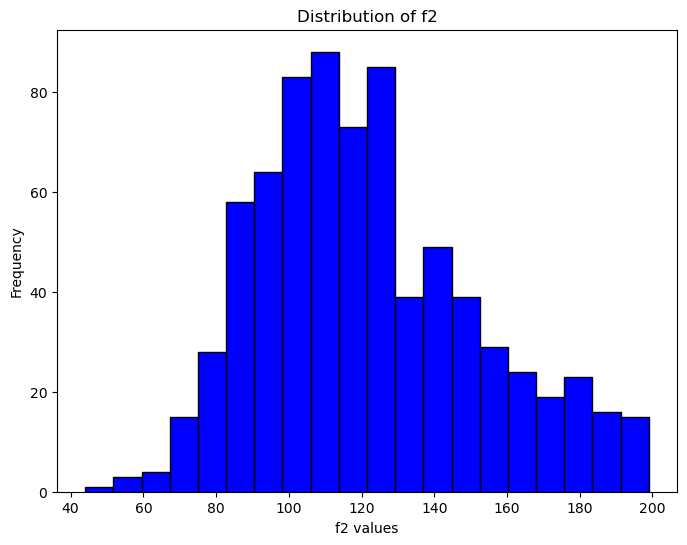

In [20]:
# F2 histogram
plt.figure(figsize=(8, 6))
plt.hist(df['f2'].dropna(), bins=20, color='blue', edgecolor='black')
plt.title('Distribution of f2')
plt.xlabel('f2 values')
plt.ylabel('Frequency')
plt.show()


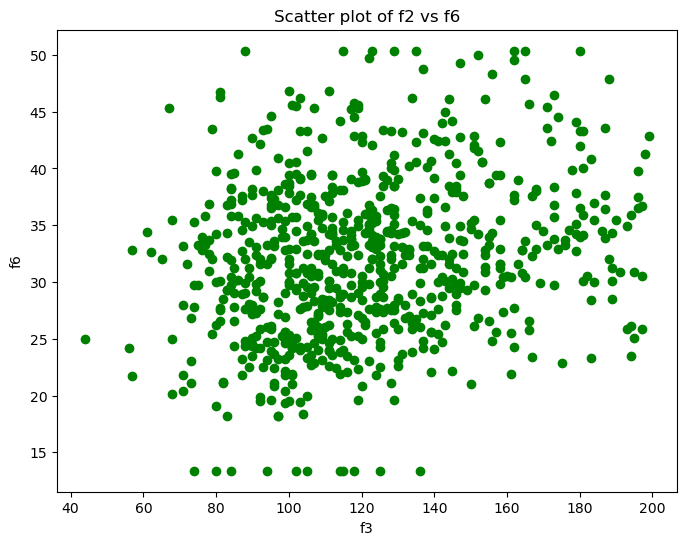

In [21]:
# f3 and f6 scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['f2'], df['f6'], color='green')
plt.title('Scatter plot of f2 vs f6')
plt.xlabel('f3')
plt.ylabel('f6')
plt.show()



<Figure size 800x600 with 0 Axes>

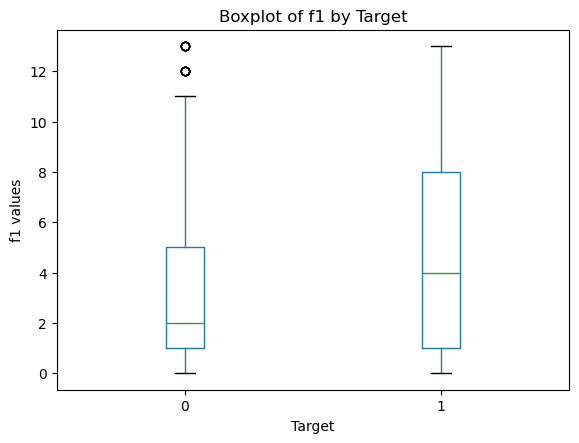

In [22]:
# f1 boxplot
plt.figure(figsize=(8, 6))
df.boxplot(column='f1', by='target', grid=False)
plt.title('Boxplot of f1 by Target')
plt.suptitle('')
plt.xlabel('Target')
plt.ylabel('f1 values')
plt.show()

---

---

# STEP 2

In [23]:
X = df.drop('target', axis=1)
y = df['target']


In [24]:
X 


,f1,f2,f3,f4,f5,f6,f7
0,6.0,148.0,72.0,35.0,0.0,33.6,0.62700
1,1.0,85.0,66.0,29.0,0.0,26.6,0.35100
2,8.0,183.0,64.0,0.0,0.0,23.3,0.67200
3,1.0,89.0,66.0,23.0,94.0,28.1,0.16700
4,0.0,137.0,40.0,35.0,168.0,43.1,1.20025
...,...,...,...,...,...,...,...
761,9.0,89.0,62.0,0.0,0.0,22.5,NaN
762,10.0,101.0,76.0,48.0,180.0,NaN,0.17100
763,2.0,122.0,70.0,27.0,NaN,36.8,0.34000
764,NaN,121.0,72.0,23.0,112.0,26.2,0.24500


In [25]:
y

0      1
1      0
2      1
3      0
4      1
      ..
761    0
762    0
763    0
764    0
765    1
Name: target, Length: 756, dtype: int64

In [26]:
numcols = X.select_dtypes(include=['int64', 'float64']).columns
print(numcols.tolist())

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']


## 2.1 Preprocess data Scale numerical variables

In [27]:
scaler = StandardScaler()
X[numcols] = scaler.fit_transform(X[numcols])

In [28]:
X

,f1,f2,f3,f4,f5,f6,f7
0,0.669324,0.873572,0.089436,0.932894,-0.789071,0.212925,0.584166
1,-0.851867,-1.202444,-0.331395,0.551657,-0.789071,-0.777599,-0.380213
2,1.277800,2.026915,-0.471672,-1.290988,-0.789071,-1.244561,0.741402
3,-0.851867,-1.070634,-0.331395,0.170420,0.205488,-0.565344,-1.023133
4,-1.156105,0.511093,-2.154998,0.932894,0.988438,1.557208,2.587175
...,...,...,...,...,...,...,...
761,1.582038,-1.070634,-0.611950,-1.290988,-0.789071,-1.357763,NaN
762,1.886276,-0.675202,0.369990,1.758908,1.115403,NaN,-1.009156
763,-0.547629,0.016804,-0.050841,0.424578,NaN,0.665736,-0.418649
764,NaN,-0.016149,0.089436,0.170420,0.395935,-0.834201,-0.750591


In [29]:
imputer = SimpleImputer(strategy='mean')
X[numcols] = imputer.fit_transform(X[numcols])

In [30]:
X

,f1,f2,f3,f4,f5,f6,f7
0,6.693238e-01,0.873572,0.089436,9.328944e-01,-7.890712e-01,2.129253e-01,5.841660e-01
1,-8.518666e-01,-1.202444,-0.331395,5.516574e-01,-7.890712e-01,-7.775992e-01,-3.802131e-01
2,1.277800e+00,2.026915,-0.471672,-1.290988e+00,-7.890712e-01,-1.244561e+00,7.414018e-01
3,-8.518666e-01,-1.070634,-0.331395,1.704205e-01,2.054878e-01,-5.653439e-01,-1.023133e+00
4,-1.156105e+00,0.511093,-2.154998,9.328944e-01,9.884384e-01,1.557208e+00,2.587175e+00
...,...,...,...,...,...,...,...
761,1.582038e+00,-1.070634,-0.611950,-1.290988e+00,-7.890712e-01,-1.357763e+00,-1.882232e-17
762,1.886276e+00,-0.675202,0.369990,1.758908e+00,1.115403e+00,1.129339e-16,-1.009156e+00
763,-5.476285e-01,0.016804,-0.050841,4.245784e-01,-3.293907e-17,6.657364e-01,-4.186485e-01
764,4.235023e-17,-0.016149,0.089436,1.704205e-01,3.959352e-01,-8.342006e-01,-7.505906e-01


## 2.2 Split the dataset using train_test_split

In [31]:
# split the dataframe, Train 85% Test 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#splitting training set into (82.35%) and validation (17.65%),, this makes 70-15-15 ratio of original set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42, stratify=y_train)


In [32]:
print(f"Training shape: \t", y_train.shape)
print(f"Validation shape: \t", y_val.shape)
print(f"Teesting shape: \t", y_test.shape)

Training shape: 	 (529,)
Validation shape: 	 (113,)
Teesting shape: 	 (114,)


## 2.3 Convert them to tensors

In [33]:
# conversion to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [34]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [35]:
print(f"Type of X_train_tensor: ",type(X_train_tensor))
print(f"Type of y_train_tensor: ",type(X_train_tensor))



Type of X_train_tensor:  <class 'torch.Tensor'>
Type of y_train_tensor:  <class 'torch.Tensor'>


In [36]:
print(f"Type of X_val_tensor: ",type(X_train_tensor))
print(f"Type of y_val_tensor: ",type(X_train_tensor))


Type of X_val_tensor:  <class 'torch.Tensor'>
Type of y_val_tensor:  <class 'torch.Tensor'>


In [37]:
print(f"Type of X_test_tensor: ",type(X_train_tensor))
print(f"Type of y_test_tensor: ",type(X_train_tensor))


Type of X_test_tensor:  <class 'torch.Tensor'>
Type of y_test_tensor:  <class 'torch.Tensor'>


In [38]:
# they are all tensors now.

---

---

# STEP 3

## 3.2 and 3.2 together

In [39]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_features, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3) 
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.fc3(x))          
        return x


In [40]:
input_features = X_train.shape[1]
neurons = 64

## Step 3.3 (Provide summary)

In [41]:
net = NeuralNetwork(input_features, neurons, 1).to(device)
summary(net, input_size=(1, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 1]                    65
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

---

# STEP 4

## Step 4.1 4.3

In [42]:

criterion = nn.BCELoss()
learning_rate = 0.0001
optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)



In [43]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# loading the data in batches
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

best_val_accuracy = 0.0  
num_epochs = 30

history = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "test_accuracy": [],
    "test_loss": []
}

In [44]:
total_start_time = time.time()

## Step 4.3, 4.4 and 4.5

In [45]:
for epoch in range(num_epochs):
    
    epoch_start_time = time.time() 
    
    #START TRAINING MODE
    net.train()  
    
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # clearing gradients
        
        # forward pass
        loss = criterion(net(inputs), labels.view(-1, 1))
        #backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # calculate the total correct values predicted
        correct_train += (net(inputs).round() == labels.view(-1, 1)).sum().item()
        total_train += labels.size(0)

    traaccuracy = correct_train / total_train
    history['train_loss'].append(running_loss / len(train_loader))
    history['train_accuracy'].append(traaccuracy)

    
    
    
    
    #START VALIDATION PHASE
    net.eval()  
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad(): # disabling gradients
        for val_inputs, val_labels in val_loader:
            
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            val_loss += criterion(val_outputs, val_labels.view(-1, 1)).item()
            
            correct_val += (val_outputs.round() == val_labels.view(-1, 1)).sum().item()
            total_val += val_labels.size(0)

    val_accuracy = correct_val / total_val
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_accuracy'].append(val_accuracy)

    
    
    
    epoch_end_time = time.time()  
    epoch_time = epoch_end_time - epoch_start_time

    print("Epoch [", epoch+1, "/", num_epochs, "], ")
    print("Training Loss:", running_loss/len(train_loader))
    print("Validation Loss:", val_loss/len(val_loader))
    print("Validation Accuracy:", val_accuracy)
    print("Time per epoch:", epoch_time, "seconds")

    
    
    
    
    
    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(net.state_dict(), 'minazmeh_aramired_assignment2_part1.pt')
        print("Best model saved at epoch", epoch+1, "with validation accuracy:", format(best_val_accuracy, ".4f"))


Epoch [ 1 / 30 ], 
Training Loss: 0.6719929505796993
Validation Loss: 0.6667802929878235
Validation Accuracy: 0.6460176991150443
Time per epoch: 0.032486915588378906 seconds
Best model saved at epoch 1 with validation accuracy: 0.6460
Epoch [ 2 / 30 ], 
Training Loss: 0.6489291506655076
Validation Loss: 0.6538924872875214
Validation Accuracy: 0.6637168141592921
Time per epoch: 0.007459163665771484 seconds
Best model saved at epoch 2 with validation accuracy: 0.6637
Epoch [ 3 / 30 ], 
Training Loss: 0.6335379095638499
Validation Loss: 0.643258586525917
Validation Accuracy: 0.6548672566371682
Time per epoch: 0.007452964782714844 seconds
Epoch [ 4 / 30 ], 
Training Loss: 0.6207960844039917
Validation Loss: 0.6341278702020645
Validation Accuracy: 0.6637168141592921
Time per epoch: 0.00774383544921875 seconds
Epoch [ 5 / 30 ], 
Training Loss: 0.6076034272418303
Validation Loss: 0.6257462203502655
Validation Accuracy: 0.6637168141592921
Time per epoch: 0.006927013397216797 seconds
Epoch [ 6 

## Step 4.6

In [46]:
net.load_state_dict(torch.load('minazmeh_aramired_assignment2_part1.pt'))
net.eval() 

with torch.no_grad():# Disable gradient
    
    test_outputs = net(X_test_tensor.to(device))
    
    # ROUNDING PREDICTIONS AS WE HAVE BINARY CLASSIFICATION
    test_pred = test_outputs.round()
    
    #calculate accuracy and loss
    test_accuracy = (test_pred == y_test_tensor.view(-1, 1).to(device)).float().mean().item()
    test_loss = criterion(test_outputs, y_test_tensor.view(-1, 1).to(device)).item()

    history['test_accuracy'] = [test_accuracy] * num_epochs
    history['test_loss'] = [test_loss] * num_epochs

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.cpu(), test_pred.cpu(), average='binary')

    print("Test Accuracy:", format(test_accuracy, ".4f"))
    print("Precision:", format(precision, ".4f"), ", Recall:", format(recall, ".4f"), ", F1-Score:", format(f1, ".4f"))


total_end_time = time.time() # get thee end time 
total_training_time = total_end_time - total_start_time
print("Total training time:", format(total_training_time, ".2f"), "seconds")

Test Accuracy: 0.7807
Precision: 0.7917, Recall: 0.4872, F1-Score: 0.6032
Total training time: 0.26 seconds


---

---

# STEP 4 - VISUALIZE 

## 4.7.a. Compare Train, Validation, and Test Accuracies

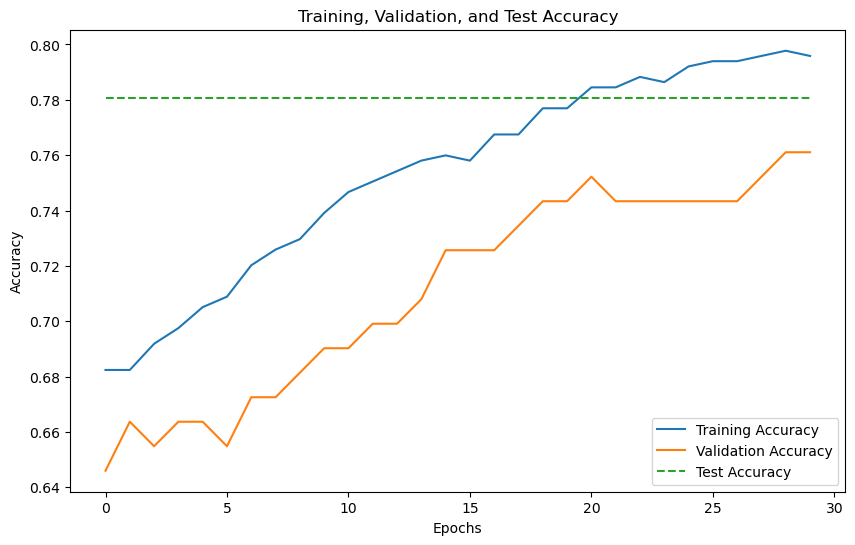

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['test_accuracy'], label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training, Validation, and Test Accuracy')
plt.show()



## 4.7.b. Compare Train, Validation and Test Losses

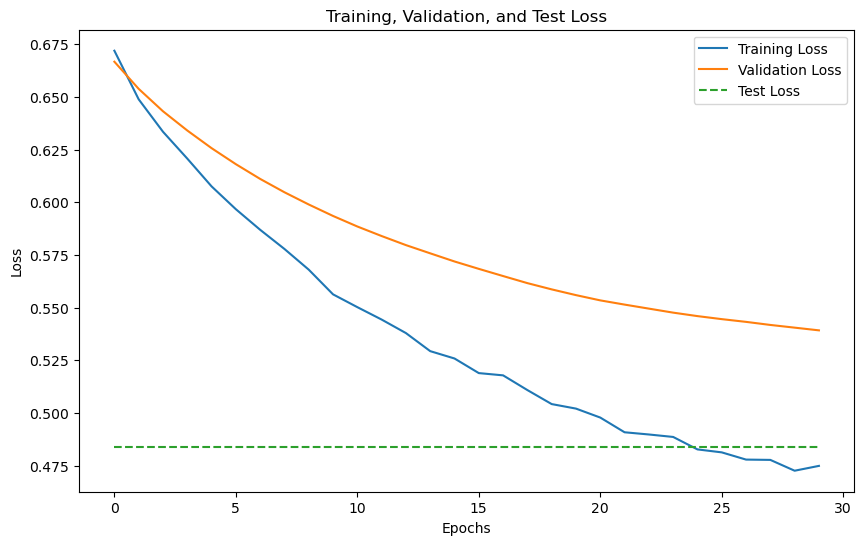

In [48]:
# Plot loss comparison (training, validation, test)
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.plot(history['test_loss'], label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Loss')
plt.show()




# 4.7.c. Confusion Matrix

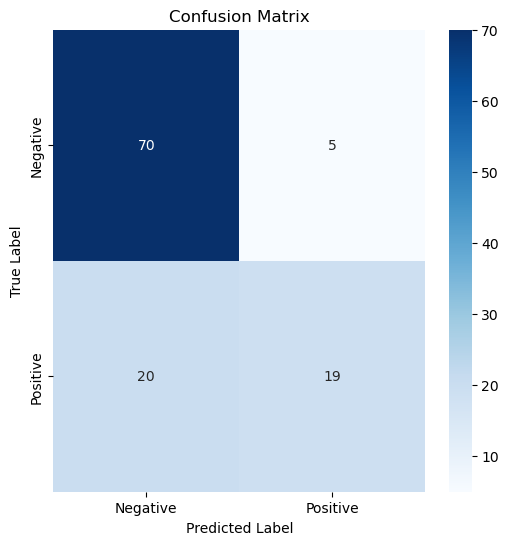

In [49]:
# Confusion Matrix
cm = confusion_matrix(y_test_tensor.cpu(), test_pred.cpu())
plt.figure(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



# 4.7.d. ROC Curve 

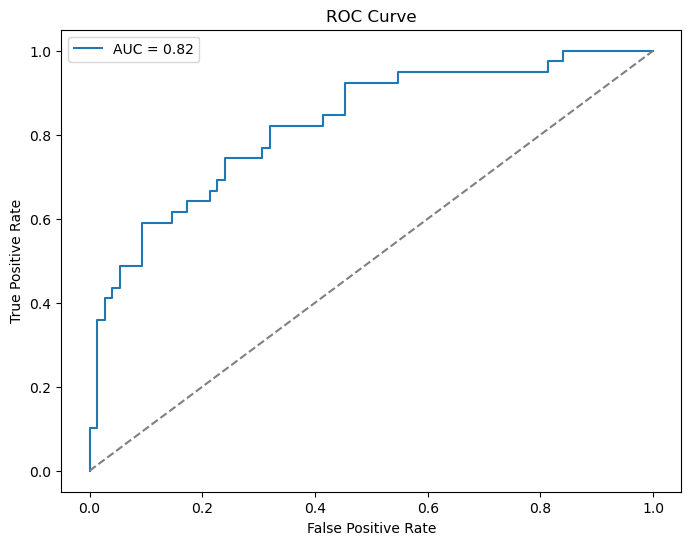

In [50]:
#ROC Curv AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu(), test_outputs.cpu())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [51]:
df.to_csv('dataset_preprocessed.csv', index=False)


---

---